In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation,Input
from tensorflow.keras.optimizers import SGD


In [ ]:
fpath = r"C:\Users\tonyj\Downloads\archive\PlantVillage"
random_seed = 111

categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus'] 

No. of categories =  15


In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category)[:300]:
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                #print(f"\nCategory = {category}, Image name = {image_name}")
                img = cv2.imread(fpath+"/"+category+"/"+image_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img_array = Image.fromarray(img, 'RGB')

                #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
                resized_img = img_array.resize((227, 227))

                img_lst.append(np.array(resized_img))

                labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  7024 
No. of labels loaded =  7024
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (7024, 227, 227, 3) 
Labels shape =  (7024,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


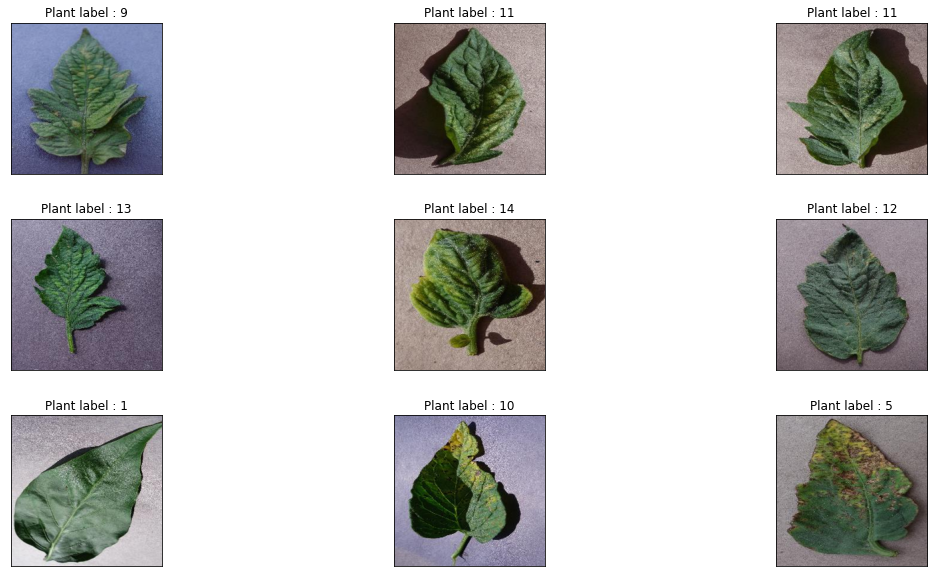

In [ ]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Plant label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [ ]:
(X_dev, Y_dev)=(images,labels)
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit1 = int(0.75*X_dev.shape[0]) # Train/validation split
nsplit2 = int(0.85*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit1]
Y_train = Y_dev[:nsplit1]
X_val = X_dev[nsplit1:nsplit2]
Y_val = Y_dev[nsplit1:nsplit2]

X_test = X_dev[nsplit2:]
Y_test = Y_dev[nsplit2:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)
print("\n Test set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)


Train set
Images:  (5268, 227, 227, 3)
Labels shape:  (5268,)

Validation set
Images:  (702, 227, 227, 3)
Labels shape:  (702,)

 Test set
Images:  (1054, 227, 227, 3)
Labels shape:  (1054,)


In [ ]:
# Data scaling
norm_type=0
if norm_type==0:
   X_train=X_train/255
   X_val=X_val/255
   X_test=X_test/255
elif norm_type==1:
     train_mean=X_train.mean()
     train_std =X_train.std()
     X_train=(X_train-train_mean)/(X_train-train_std)
     X_val=(X_val-train_mean)/(X_train-train_std)
     X_test=(X_test-train_mean)/(X_train-train_std)
else: 
    pass
    

In [ ]:
# One hot encoding
Y_train_oh=to_categorical(Y_train)
Y_val_oh=to_categorical(Y_val)
Y_test_oh=to_categorical(Y_test)
print(Y_train[:5])
print(Y_train_oh[:5])
k=np.unique(Y_dev).size
print(k)

[ 0  9 10  0 11]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
15


In [ ]:
def my_model(ishape = (227,227,3),k = 15, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)
    l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5)
    flat = tf.keras.layers.Flatten()(l5_drop)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [ ]:
model_name="xyz"
early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=20)
monitor=tf.keras.callbacks.ModelCheckpoint(model_name,monitor="val_loss",\
                                          verbose=0,save_best_only=True,\
                                          save_weights_only=True,mode='min')
def scheduler(epoch,lr):
    if epoch%10==0:
        lr=lr/2
    return lr
lr_schedule=tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
model=my_model()
model.summary()
model.fit(X_train,Y_train_oh,batch_size=32,epochs=5,verbose=1,callbacks=[early_stop,monitor,lr_schedule],
          validation_data=(X_val,Y_val_oh),shuffle=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 227, 227, 48)      1344      
_________________________________________________________________
dropout (Dropout)            (None, 227, 227, 48)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 96)      41568     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 96)      83040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 113, 113, 96)      0     

In [ ]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test_oh)

33/33 [==============================] - 13s 390ms/step - loss: 0.6759 - accuracy: 0.7827


In [ ]:
pred = model.predict(X_test)

pred.shape

(653, 15)

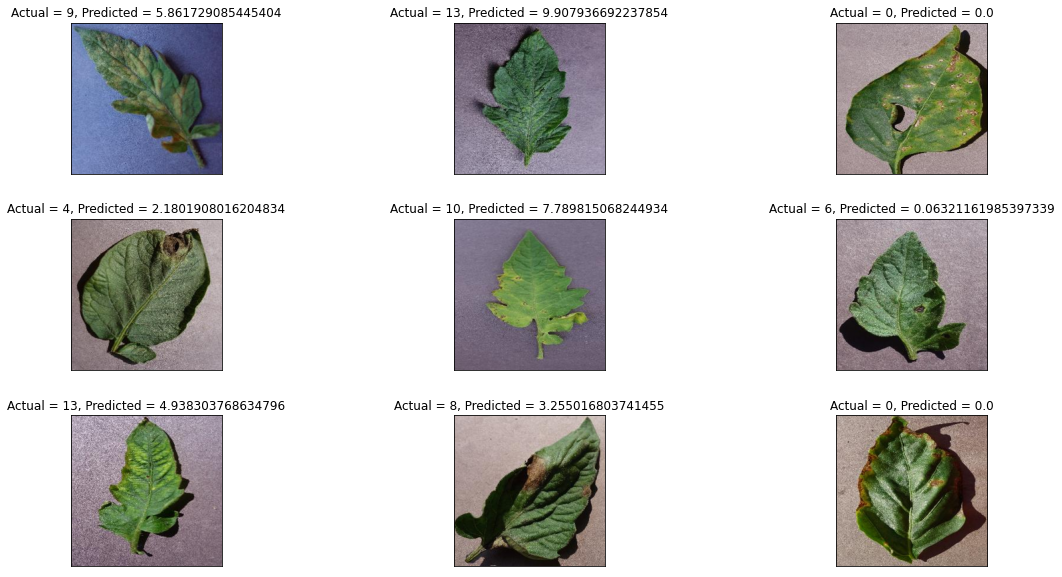

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, X_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(X_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(Y_test[r[0]] , Y_test[r[0]]*pred[r[0]][Y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()